In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
# sns.set(color_codes = True)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [7]:
jtplot.style(theme='monokai')

# Data Importing and Cleaning

### Chart Data

In [8]:
chart_df = pd.read_csv('../data/all_charts.csv')
chart_df = chart_df[['chartDate', 
                     'title', 
                     'artist', 
                     'peakPos', 
                     'lastPos',
                     'weeks',
                     'rank',
                     'change',
                     'spotifyID']]
chart_df['chartDate'] = pd.to_datetime(chart_df[('chartDate')])
chart_df['year'] = chart_df['chartDate'].dt.year
chart_df['month'] = chart_df['chartDate'].dt.month
chart_df['decade'] = (chart_df.chartDate.dt.year//10)*10
chart_df['rank_weight'] = 101 - chart_df['rank'] 

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Only keep top 10
chart_df = chart_df[chart_df['rank'] < 11]

In [10]:
##### wh check
# chart_df[(chart_df['year'] == 1993) & (chart_df['month'] == 1) & (chart_df['rank'] == 1)]#[['chartDate', 'title', 'artist', 'rank', 'month', 'year']].sort_values('chartDate')

### Spotify Data

In [11]:
spotify_df = pd.read_csv('../data/spotify_data.csv')
spotify_df = spotify_df.drop_duplicates(subset = 'track_uri') # remove one spotify dup
spotify_df['maj_minor'] = spotify_df['key_mode'].str.split(' ', 1).str[1]

### Lyrics Data

#### Import and clean data

In [12]:
lyrics_df = pd.read_csv('../data/lyrics.csv')
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()] # remove songs without lyrics
lyrics_df = lyrics_df.drop_duplicates(subset = 'spotifyID')

In [13]:
# Create TextBlob object. Extract polarity score
from textblob import TextBlob
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # converts (-1,1) score to (0,1)

#### Word Analysis

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()
word_counts.columns = ['word', 'count'] # rename columns

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


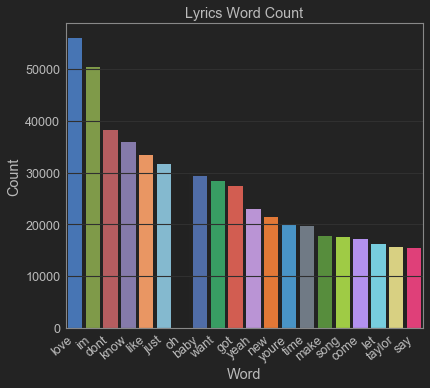

In [15]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=40, ha = 'right')
plt.title('Lyrics Word Count')
plt.show()

### Join Data

In [16]:
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')
df = pd.merge(df, lyrics_df, left_on='spotifyID', right_on = 'spotifyID', how='inner')

In [17]:
df[(df['month'] == 11) & (df['year'] == 2004) & (df['rank'] == 1)]
# chart_df[(chart_df['month'] == 11) & (chart_df['year'] == 2004) & (chart_df['rank'] == 1)]

,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,year,...,duration_ms,time_signature,key_mode,maj_minor,Song,Artist,Lyrics,Source,tb_obj,polarity
20521,2004-11-06,My Boo,Usher And Alicia Keys,1,1,9,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20522,2004-11-13,My Boo,Usher And Alicia Keys,1,1,10,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20523,2004-11-20,My Boo,Usher And Alicia Keys,1,1,11,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676
20524,2004-11-27,My Boo,Usher And Alicia Keys,1,1,12,1,0,68vgtRHr7iZHpzGpon6Jlo,2004,...,223440.0,4,F major,major,my boo,usher alicia keys,theres always that one person that will always...,2.0,"(t, h, e, r, e, s, , a, l, w, a, y, s, , t, ...",0.528676


#### Analysis

In [18]:
import operator
def quick_filter(df, bort, peak_pos_thresh = 5):        
    """
    Function quickly subsets the data for quick data searches & avoids making temporary dataframes
    It's not perfect but it's quick and helpful
    """
    spot_flds = ['chartDate', 'title', 'artist', 'peakPos', 'valence', 'energy', 'polarity', 'happy_index']
    return df[bort & (df['peakPos'] < peak_pos_thresh)][spot_flds].drop_duplicates(subset = ['title', 'artist'])

In [19]:
# Examples for valence v energy plot below

# quick_filter(df, (df['valence'] < .2) & (df['energy'] < .2))
# Can You Feel The Love Tonight by Elton John (142471)

# quick_filter(df, (df['valence'] > .8) & (df['energy'] < .4))
# Bang Bang (My Baby Shot Me Down) nancy sinatra

# quick_filter(df, (df['valence'] > .8) & (df['energy'] > .8))
# surfin usa beach boys, splish splash, if I had a hammer, timber pitbull + kesha, hey yah outcast

# quick_filter(df, (df['valence'] < .3) & (df['energy'] > .8))
# Like A Prayer	Madonna, My Sacrifice Creed

In [20]:
# create of energy quadrants
he_hv = df[(df['energy'] > .5) & (df['valence'] > .5) ].shape[0]
he_lv = df[(df['energy'] > .5) & (df['valence'] <= .5)].shape[0]
le_lv = df[(df['energy'] <= .5) &(df['valence'] <= .5)].shape[0]
le_hv = df[(df['energy'] <= .5) & (df['valence'] > .5)].shape[0]

[cnt / df.shape[0] for cnt in [he_hv, he_lv, le_lv, le_hv]]
def pretty_pct(quad_count, df = df):
    pct = quad_count / df.shape[0]
    pct = round(pct*100,2)
    return  str(pct) + '%'
pretty_pct(he_hv)

'55.78%'

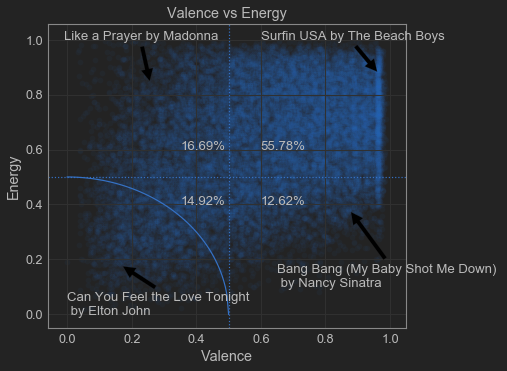

In [21]:
# Show off the differences 
plt.scatter(spotify_df['valence'], spotify_df['energy'], alpha = .05)
plt.title('Valence vs Energy')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.axvline(x=0.5, ls = 'dotted')
plt.axhline(y=0.5, ls = 'dotted')

the_x = np.linspace(0, .5, 100)
the_y = (.25 - the_x**2)**(1/2)
plt.plot(the_x, the_y)

plt.annotate('Surfin USA by The Beach Boys', xy=(0.964, 0.878), xytext = (.6,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_hv), xy=(.6,.6))

plt.annotate('Bang Bang (My Baby Shot Me Down) \n by Nancy Sinatra', xy=(0.873, 0.382), xytext = (.65,.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_hv), xy=(.6,.4))

plt.annotate('Can You Feel the Love Tonight \n by Elton John', xy=(0.1670, 0.1790), xytext = (0,0), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(le_lv), xy=(.35,.4))

plt.annotate('Like a Prayer by Madonna', xy=(0.2570, 0.842), xytext = (-.01,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(pretty_pct(he_lv), xy=(.35,.6))

plt.show()

In [22]:
# quick_filter(df, (df['polarity'] < .4))
# Bridge Over Troubled Water \n by Simon & Garfunkel

# quick_filter(df, (df['polarity'] > .65))
# You're Beautiful by James Blunt

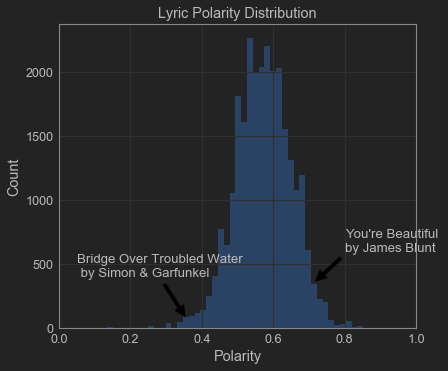

In [23]:
sns.distplot(df['polarity'], kde = False)
plt.title('Lyric Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xlim(0, 1)

plt.annotate('Bridge Over Troubled Water \n by Simon & Garfunkel', 
             xy=(0.358322, 70), 
             xytext = (.05, 400), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("You're Beautiful \nby James Blunt", 
             xy=(0.712690, 350), 
             xytext = (.8, 600), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

Create Happy_Index by combining *valence* and *energy* from Spotify with the *polarity* of the Lyrics -- while normalizing. 

In [24]:
from sklearn.metrics.pairwise import euclidean_distances
coord = df['coord'] =[[df['valence'].iloc[i], df['energy'].iloc[i]] for i in range(df.shape[0])]
df['euclidean_dist'] = euclidean_distances(coord, [[0, 0]])

df['euc_dist_normed'] = df['euclidean_dist'] / (2**(1/2)) # euclidian dist between (0,0) & (1,1)
df['happy_index'] = (df['euc_dist_normed'] + df['polarity'])/2
df['happy_flag'] = np.where(df['happy_index'] > .5, 1, 0)

In [25]:
# quick_filter(df, (df['happy_index'] < .4))
# Without You \n by Harry Nilsson 0.396429

# quick_filter(df, (df['happy_index'] > .8))
# I Feel Fine by The Beatles  0.817876

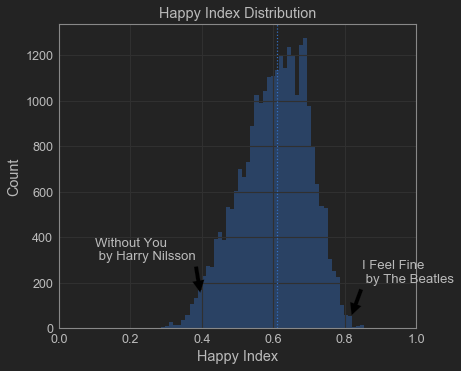

In [26]:
sns.distplot(df['happy_index'], kde = False)
plt.title('Happy Index Distribution')
plt.xlabel('Happy Index')
plt.ylabel('Count')
plt.xlim(0, 1)
plt.axvline(x = df['happy_index'].median(), ls = 'dotted') # add vertical line for the median

plt.annotate('Without You \n by Harry Nilsson', 
             xy=(0.396429, 150), 
             xytext = (.1, 300), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate("I Feel Fine \n by The Beatles", 
             xy=(0.817876,50), 
             xytext = (.85, 200), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

#### Over Time

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


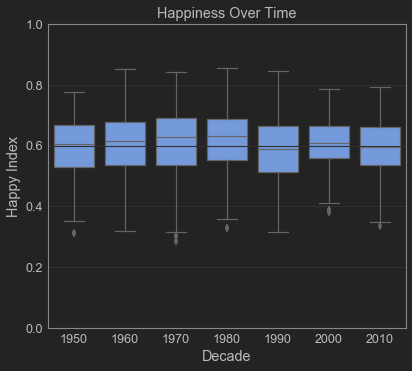

In [27]:
sns.boxplot(x = 'decade', y = 'happy_index', data = df,
            color = '#6495ED')
plt.title('Happiness Over Time')
plt.xlabel('Decade')
plt.ylabel('Happy Index')
plt.ylim(0, 1)
plt.show()

#### Missing Data

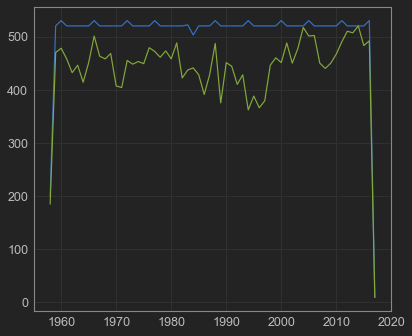

All chart totals: 30455 
Merged Dataset: 26419 
Percent Coverage: 86.75%


In [28]:
chart_year = chart_df.groupby('year')['rank'].count().reset_index(name = 'count')
df_year = df.groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year['year'], chart_year['count'])
plt.plot(df_year['year'], df_year['count'])
plt.show()
print('All chart totals: ' + str(chart_year['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year['count'].sum() / chart_year['count'].sum()*100,2)) + '%')

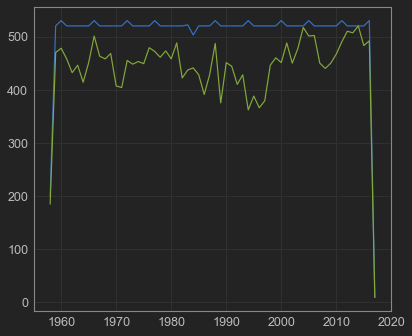

All chart totals: 30455 
Merged Dataset: 26419 
Percent Coverage: 86.75%


In [29]:
chart_year_10 = chart_df[chart_df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
df_year_10 = df[df['rank'] < 11].groupby('year')['rank'].count().reset_index(name = 'count')
plt.plot(chart_year_10['year'], chart_year_10['count'])
plt.plot(df_year_10['year'], df_year_10['count'])
plt.show()
print('All chart totals: ' + str(chart_year_10['count'].sum()), 
      '\nMerged Dataset: ' + str(df_year_10['count'].sum()),
      '\nPercent Coverage: ' + str(round(df_year_10['count'].sum() / chart_year_10['count'].sum()*100,2)) + '%')

## add in external predictors

Group Bilboard to Month

In [30]:
df_month = df.groupby(['year', 'month', 'decade'])[['happy_index', 'valence', 'energy', 'polarity']].mean().reset_index()

In [31]:
# multiple aggregations. Drives me crazy that this is the best way to do this
def compute_metrics(x):
    result = {'happy_index_min': x['happy_index'].min(), 
              'happy_index_mean': x['happy_index'].mean(),
              'count': x['happy_index'].count()}
    return pd.Series(result)
df_month = df.groupby(['year', 'month', 'decade']).apply(compute_metrics).reset_index()

In [32]:
df_month['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(df_month.month, np.ones(df_month.shape[0]).astype(int), df_month.year)]
df_month_date = df_month.set_index('dates')

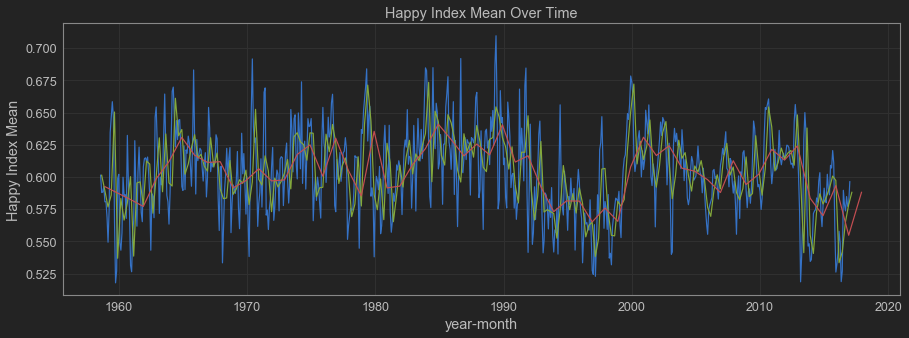

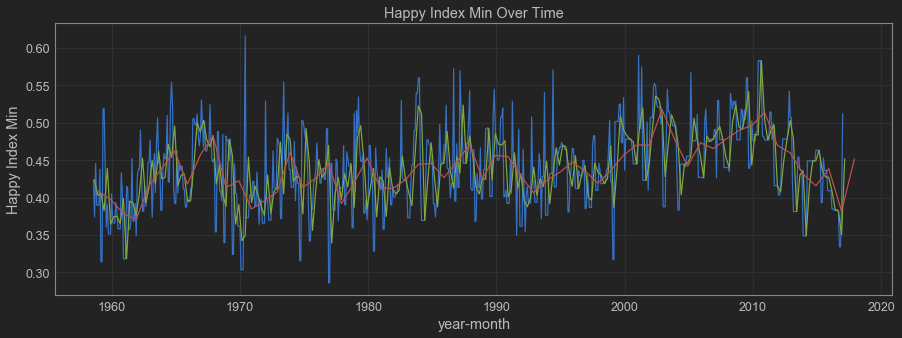

In [33]:
plt.subplots(figsize = (15,5))
plt.plot(df_month_date['happy_index_mean'])
plt.plot(df_month_date.resample('Q-NOV')['happy_index_mean'].mean())
plt.plot(df_month_date.resample('A-NOV')['happy_index_mean'].mean())

plt.title('Happy Index Mean Over Time')
plt.xlabel('year-month')
plt.ylabel('Happy Index Mean')
# plt.ylim(0, 1)
plt.show()

plt.subplots(figsize = (15,5))
plt.plot(df_month_date['happy_index_min'])
plt.plot(df_month_date.resample('Q-NOV')['happy_index_min'].mean())
plt.plot(df_month_date.resample('A-NOV')['happy_index_min'].mean())

plt.title('Happy Index Min Over Time')
plt.xlabel('year-month')
plt.ylabel('Happy Index Min')
# plt.ylim(0, 1)
plt.show()

Import SnP and clean

In [34]:
snp_df = pd.read_csv('../data/daily_snp500.csv')
snp_df['Date'] = pd.to_datetime(snp_df[('Date')])
snp_df['year'] = snp_df['Date'].dt.year
snp_df['month'] = snp_df['Date'].dt.month
snp_df['Mid'] = (snp_df['High'] + snp_df['Low'])/2

In [35]:
# aggregate snp
def snp_agg(x):
    result = {'snp_high': x['High'].max(), 
              'snp_low': x['Low'].min(),
              'snp_mid': x['Mid'].mean(),
              'snp_vol': x['Volume'].sum()}
    return pd.Series(result)

snp_month_df = snp_df.groupby(['year', 'month']).apply(snp_agg).reset_index()

In [36]:
# merge snp with music data
df_month = pd.merge(df_month, snp_month_df)

Import CCI

In [37]:
# import consumer confidence index
cci_df = pd.read_csv('../data/cci.csv')
# only keep important information
cci_df = cci_df[cci_df['LOCATION'] == 'USA'][['TIME', 'Value']]
cci_df['TIME'] = pd.to_datetime(cci_df['TIME'])
cci_df['month'] = cci_df['TIME'].dt.month
cci_df['year'] = cci_df['TIME'].dt.year
cci_df = cci_df.rename(index=str, columns = {'Value': 'cci_value'})
cci_df = cci_df.drop('TIME', axis = 1)

In [38]:
# merge cci with music data
df_month = pd.merge(df_month, cci_df)

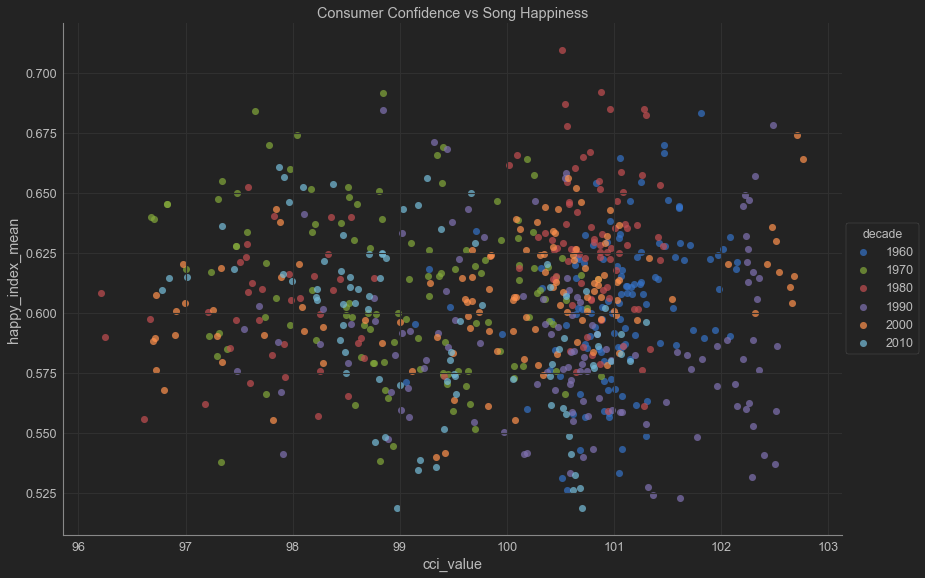

In [39]:
# sns.regplot(x="cci_value", y="happy_index", data=df_month)
sns.lmplot(x = "cci_value", 
           y = "happy_index_mean", 
           data = df_month,
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})
plt.title('Consumer Confidence vs Song Happiness')
plt.show()

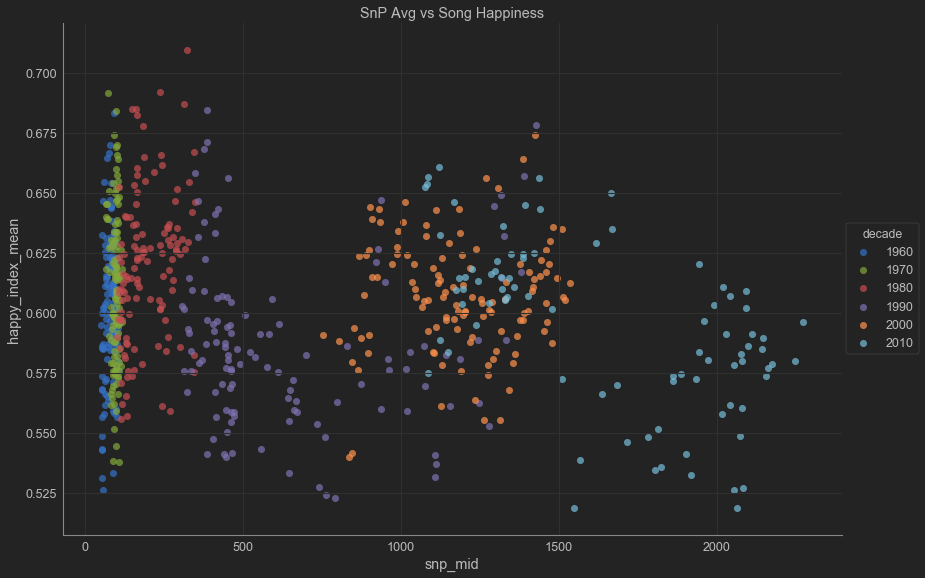

In [40]:
sns.lmplot(x="snp_mid", 
           y="happy_index_mean", 
           data=df_month, 
           fit_reg = False, hue = 'decade', size=8, aspect=1.5, scatter_kws={'alpha':0.7,"s": 50})

plt.title('SnP Avg vs Song Happiness')
plt.show()

In [41]:
# filter & agg for unhappy tracks that made #1 billboard
flag_df = df[(df['happy_flag'] == 0) & (df['rank'] == 1)]\
              .groupby(['year', 'month'])\
              .apply(compute_metrics).reset_index()

In [42]:
# convert year and month to datetime, create index, fill in months with no sad songs with 0
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]
flag_df = flag_df.set_index('dates')
flag_df = flag_df.resample('M').mean().fillna(0)

# create month and year with index b/c fields were filtered  and now have nans
flag_df['month'] = flag_df.index.month
flag_df['year'] = flag_df.index.year

# create flag to show if month had any sad #1 hits
flag_df['sad_hit_flag'] = np.where(flag_df['count'] != 0, 1, 0)

In [43]:
flag_df = pd.merge(flag_df, snp_month_df)
flag_df = pd.merge(flag_df, cci_df)

In [44]:
flag_df['dates'] = [pd.to_datetime(str(a)+str(b)+str(c), format='%m%d%Y') for a,b,c in zip(flag_df.month, np.ones(flag_df.shape[0]).astype(int), flag_df.year)]
flag_df = flag_df.set_index('dates')

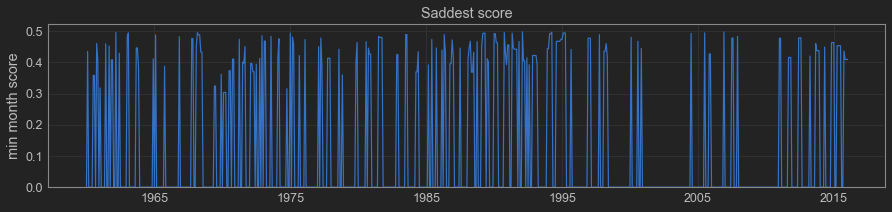

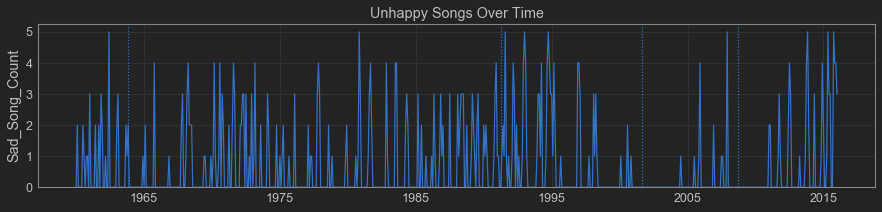

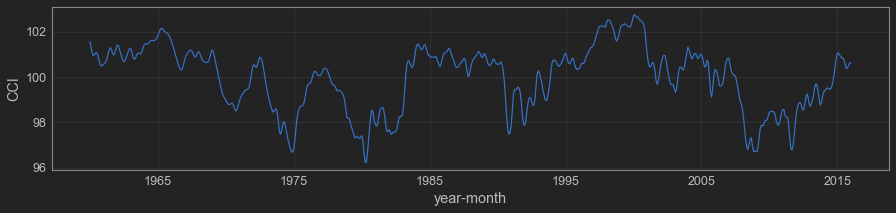

In [45]:
plt.subplots(figsize=(15,3))

plt.plot(flag_df['happy_index_min'])

plt.title('Saddest score')
plt.ylabel('min month score')
plt.ylim(0)
plt.show()

plt.subplots(figsize=(15,3))

plt.plot(flag_df['count'])
plt.axvline(x='1963-10-22', ls = 'dotted') # JFK 
plt.axvline(x='1991-04-09', ls = 'dotted') # berlin wall down 
# plt.axvline(x='1998-09-09', ls = 'dotted') # around the time of bill clinton bj
plt.axvline(x='2001-09-01', ls = 'dotted') # 9/11
plt.axvline(x='2008-09-15', ls = 'dotted') # stock mkt crash


plt.title('Unhappy Songs Over Time')
plt.ylabel('Sad_Song_Count')
plt.ylim(0)
plt.show()

##### Plot 2 #####

plt.subplots(figsize=(15,3))

plt.plot(flag_df['cci_value'])
plt.xlabel('year-month')
plt.ylabel('CCI')
plt.show()

In [46]:
# fit cubic or quartic smoothing
# what is the gradient

In [47]:
from scipy.signal import savgol_filter
# savgol_filter(flag_df['cci_value'], 5, 2)

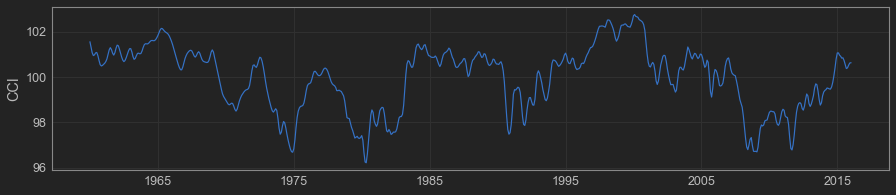

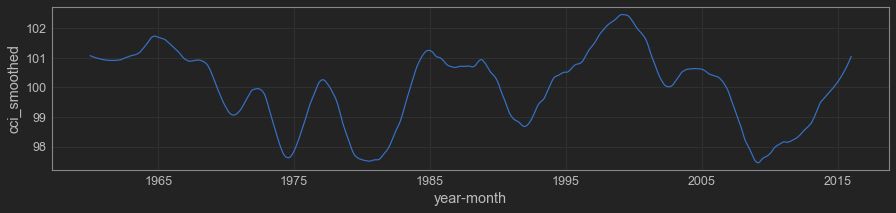

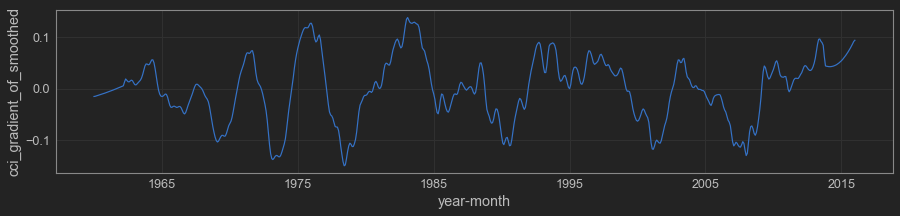

In [48]:
plt.subplots(figsize=(15,3))

plt.plot(flag_df['cci_value'])
plt.ylabel('CCI')
plt.show()

plt.subplots(figsize=(15,3))
flag_df['smooth_cci'] = savgol_filter(flag_df['cci_value'], 55, 3)

plt.plot(flag_df['smooth_cci'])
plt.xlabel('year-month')
plt.ylabel('cci_smoothed')

plt.show()

plt.subplots(figsize=(15,3))
flag_df['cci_gradient_smooth'] = np.gradient(flag_df['smooth_cci'])
plt.plot(flag_df['cci_gradient_smooth'])
plt.xlabel('year-month')
plt.ylabel('cci_gradient_of_smoothed')

plt.show()

In [49]:
flag_df.groupby('sad_hit_flag')['year'].count().reset_index(name = 'count')

,sad_hit_flag,count
0,0,479
1,1,194


In [50]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(flag_df[['cci_gradient_smooth']], flag_df['sad_hit_flag'])
lr.score(flag_df[['cci_gradient_smooth']], flag_df['sad_hit_flag'])

0.71173848439821696

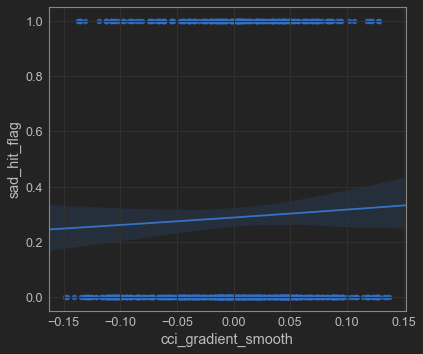

In [51]:
sns.regplot(x = 'cci_gradient_smooth', y = 'sad_hit_flag', data = flag_df, logistic = True)

In [52]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
logit = sm.Logit(flag_df['sad_hit_flag'].values, flag_df['cci_gradient_smooth'].values)
result = logit.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.692573
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  673
Model:                          Logit   Df Residuals:                      672
Method:                           MLE   Df Model:                            0
Date:                Wed, 17 Jan 2018   Pseudo R-squ.:                 -0.1532
Time:                        11:21:49   Log-Likelihood:                -466.10
converged:                       True   LL-Null:                       -404.20
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1057      1.259      0.878      0.380      -1.362       3.573


/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [53]:
df.drop('tb_obj', axis = 1).to_pickle('../data/df.pkl')

In [ ]:
bortbort = df[(df['rank'] == 1) & (df['happy_index'] < .5 )].groupby(['title', 'month', 'year'])['happy_index'].count().reset_index()
bortbort[bortbort['happy_index'] == 5].sort_values('year')

As soon as the berlin wall fell down. Mariah Carey told us how she didn't Wanna Cry followed by a month and a half of bryan adams telling us how he'd do anything for us. 

In [ ]:
df[(df['year'] == 1991) & (df['rank'] == 1) & (df['happy_index'] < .5 )].groupby(['title', 'month'])['happy_index'].count().reset_index()

When will a somber song succeed

5 months smoothing

In [ ]:
quick_filter(df, (df['title'] == 'Turn Down For What') & (df['rank'] == 5))

In [ ]:
quick_filter(df, df['chartDate'] == '2014-05-10') 

In [ ]:
quick_filter(df, (df['happy_index'] < .5) & (df['rank'] == 1))